In [44]:
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import tellurium as te
from odbm.odbm import ModelBuilder
import matplotlib.pyplot as plt
from odbm.vis import rxn_plot


In [49]:
model_species = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Species & Base Mechanisms', engine = 'openpyxl')
model_rxns = pd.read_excel('Examples/multi_enzyme_model.xlsx', sheet_name = 'Reaction', engine = 'openpyxl')

In [50]:
expression_limit = 0.05 
N_enzymes = 3
expression_fudge = 1/10
enzymeInit = expression_limit/N_enzymes*expression_fudge

solubilities = {    'ATP' : 98.619,
                    'Serine': 2380.952,
                    'HCO3' : 1470.588,
                    'NADH' : 150.739 
                }
sol_fudge = 1/20
solubilities = {k:v*sol_fudge for k,v in solubilities.items()}

for k,v in solubilities.items():
    model_species.loc[model_species['Label'] == k,'StartingConc'] = v

# this doesn't work
model_species.loc[model_species['Label'] == 'ATP','Label'] = '$ATP'
model_species.loc[model_species['Label'] == 'ATP','StartingConc'] = solubilities['ATP']

serine_mw = 105.09
malate_mw = 134.0874

In [51]:
modelfile = 'Examples/multi_enzyme_model.txt'
myModel = ModelBuilder(model_species, model_rxns)
myModel.saveModel(modelfile)

model = open(modelfile,'r').read()
r  = te.loada(model)

sdaV = list(map(lambda x:x.upper(),model_species[['Sda' in s for s in model_species['Label']]]['Label']))
pcxV = list(map(lambda x:x.upper(),model_species[['PCX' in s for s in model_species['Label']]]['Label']))
mdhV = list(map(lambda x:x.upper(),model_species[['Mdh' in s for s in model_species['Label']]]['Label']))

TypeError: can only concatenate str (not "list") to str

In [34]:
results_id = np.empty((len(sdaV), len(pcxV), len(mdhV)), dtype=int)
results = []

count = 0
for i,sda in enumerate(sdaV):
    for j,pcx in enumerate(pcxV):
        for k,mdh in enumerate(mdhV):
            r['['+sda+']'] = enzymeInit
            r['['+pcx+']'] = enzymeInit
            r['['+mdh+']'] = enzymeInit
            results_id[i,j,k] = count
            results.append(r.simulate(0,1200,1000))
            r.reset()
            count += 1

In [8]:

# for sim in results[16:24]:
#     plt.figure()
#     for species in sim[1:]:
#         plt.plot(sim[0],species)
#     # plt.legend(labels = ['Serine','Pyruvate','Oxaloacetate', 'Malate'])



In [ ]:
variants = (0,0,0)
v_labels = [v[k] for v,k in zip([sdaV, pcxV, mdhV], variants)]
run = int(results_id[variants])
rxns = [variants[0],variants[1]+4, variants[2]+8]
rxn_plot(myModel, results[run], rxns, figsize=(16,4), titles = v_labels);

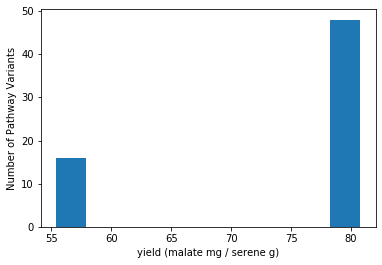

In [36]:
plt.hist([((r['[MALICACID]'][-1]*malate_mw)/(r['[SERINE]'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');

In [28]:
results[0]

       time,    [SERINE], [CO2], [PYRUVICACID], [OXALOACETICACID], [ADP],  [NADH], [NAD_plus], [SDA_MSMEG],  [SDA_BSUB], [SDA_ECOLI], [SDA_LPNEU], [PCX_RETLI], [PCX_SCER], [PCX_MSMEG], [PCX_GTHERM], [MDH_ECOLI],   [MDH_MDOM],  [MDH_REMER], [MDH_TAES],   [NH3], [ATP], [MALICACID]
 [[       0,     119.048,    50,            33,                 4,     0, 7.53695,          0,  0.00166667,           0,           0,           0,  0.00166667,          0,           0,            0,  0.00166667,            0,            0,          0,       0,     0,           0],
  [  1.2012,     118.047,    50,        34.001,           3.22575,     0,  6.7627,   0.774251,  0.00166667,           0,           0,           0,  0.00166667,          0,           0,            0,  0.00166667,            0,            0,          0, 1.00098,     0,    0.774251],
  [  2.4024,     117.046,    50,        35.002,           2.55141,     0, 6.08836,    1.44859,  0.00166667,           0,           0,           0,  0.001666

In [37]:
#dummy test of different enzyme ratios 
#testing just one combination of enzyme variants

ratios = [1,5,10]
results_id = np.empty((len(ratios), len(ratios), len(ratios)), dtype=int)
results = []
count = 0

for i in ratios:
    for j in ratios:
        for k in ratios:
            r['['+sdaV[0]+']'] = enzymeInit*(i/sum(ratios))
            r['['+pcxV[0]+']'] = enzymeInit*(j/sum(ratios))
            r['['+mdhV[0]+']'] = enzymeInit*(k/sum(ratios))

            #results_id[i-1,j-1,k-1] = count
            results.append(r.simulate(0,1200,1000))
            r.reset()
            count += 1

In [ ]:
'''
species = ['[SERINE]','[PYRUVICACID]','[OXALOACETICACID]', '[MALICACID]']
sample = [0, 5, 10, 15, 20, 25]
for s in sample:
    sim = results[s]
    plt.figure()
    for sp in species:
        plt.plot(sim['time'],sim[sp])
        plt.legend(labels = ['Serine','Pyruvate','Oxaloacetate', 'Malate'])
'''

sample = [0, 5, 10, 15, 20, 25]
for s in sample:
    sim = results[s]
    plt.figure()
    plt.plot(sim['time'],sim['[MALICACID]'])




In [ ]:
sim

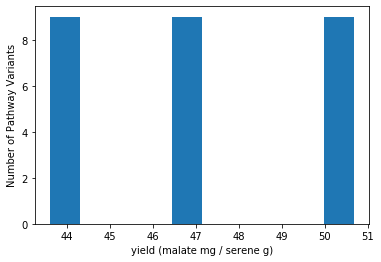

In [39]:
plt.hist([((r['[MALICACID]'][-1]*malate_mw)/(r['[SERINE]'][0]*serine_mw)*1000) for r in results]);
plt.xlabel('yield (malate mg / serene g)');
plt.ylabel('Number of Pathway Variants');